<a href="https://colab.research.google.com/github/nedokormysh/NLP_Fontanka/blob/main/Pymagic_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.figure
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
import datetime
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
import collections

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

In [ ]:
df = pd.read_csv(f'https://github.com/nedokormysh/NLP_Fontanka/raw/main/data/fontanka.csv')
# df = pd.read_csv(f'content/fontanka.csv')

# EDA

Хотим решать задачу классификации текстов по темам.

Выведем несколько строк

In [ ]:
df.head(5)

,url,title,content,topic,datetime,views,comments_amount
0,https://www.fontanka.ru/2022/01/01/70356794/,Смогли повторить. Петербуржцы продолжили празд...,Вечер 1 января показал: у петербуржцев достато...,Город,2022-01-01 23:15:00,30940,19
1,https://www.fontanka.ru/2022/01/01/70356791/,Как обложка альбома. Первое в 2022 году северн...,Охотники за огнями Авроры начали новый год за ...,Город,2022-01-01 22:33:00,13062,3
2,https://www.fontanka.ru/2022/01/01/70356788/,Роулинг достали из архива. Какие тайны раскрыл...,Поклонники Гарри Поттера со всего мира смотрят...,Общество,2022-01-01 22:20:00,12050,0
3,https://www.fontanka.ru/2022/01/01/70356782/,Первый закат нового года засняли петербуржцы в...,Фото на фоне закатного солнца сняли жители Пет...,Город,2022-01-01 21:25:00,13591,1
4,https://www.fontanka.ru/2022/01/01/70356677/,В Хургаде 1 января выпал град. Туристы рады,Египетский курорт засыпало градом 1 января. В ...,Общество,2022-01-01 20:33:00,15892,9


In [ ]:
# Переводим тэги к нижнему регистру
df['topic']= df['topic'].apply(lambda x: x.lower())

Размер датасета

In [ ]:
df.shape

(46348, 7)

### Общая информация о датафрейме

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46348 entries, 0 to 46347
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              46348 non-null  object
 1   title            46348 non-null  object
 2   content          46324 non-null  object
 3   topic            46348 non-null  object
 4   datetime         46348 non-null  object
 5   views            46348 non-null  int64 
 6   comments_amount  46348 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.5+ MB


### Кол-во пропусков

In [ ]:
df.isna().sum()

url                 0
title               0
content            24
topic               0
datetime            0
views               0
comments_amount     0
dtype: int64

In [ ]:
f"Доля пропусков в признаке 'content': {round(df['content'].isna().sum() / df.shape[0]*100, 2)}%"

"Доля пропусков в признаке 'content': 0.05%"

На некоторых страницах сервер обрывал соединение. Но количество таких строк мало, поэтому предполагаю, что можно не использовать эти пропущенные объекты.

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().any().any()

False

### Основные описательные статистики

In [ ]:
df.describe()

,views,comments_amount
count,4.632400e+04,46324.000000
mean,1.521706e+04,23.928978
std,2.405670e+04,38.418683
min,3.320000e+02,0.000000
25%,6.355000e+03,4.000000
50%,9.542000e+03,12.000000
75%,1.590600e+04,29.000000
max,1.635672e+06,989.000000


In [ ]:
df.describe(exclude='int')

,url,title,content,topic,datetime
count,46324,46324,46324,46324,46324
unique,46324,46237,46324,17,46093
top,https://www.fontanka.ru/2022/01/01/70356794/,«Итоги недели» с Андреем Константиновым,Вечер 1 января показал: у петербуржцев достато...,происшествия,2022-04-25 14:55:00
freq,1,41,1,15228,3


### Распределение целевой переменной: новостей по темам

In [ ]:
df.topic.value_counts()

topic
происшествия     15228
общество         13418
город             7778
власть            3337
спорт             1611
бизнес            1582
политика           936
авто               580
финансы            565
строительство      437
технологии         291
туризм             224
доброе дело        189
образ жизни         93
недвижимость        39
особое мнение       15
доктор питер         1
Name: count, dtype: int64

У нас сильная несбалансированность в выборке, причём некоторые темы встречаются абсолютно минимальное количество раз, обучиться на них мы не сможем, поэтому решил выбросить их из наших данных

In [ ]:
# Получаем количество значений в столбце topic
topic_counts = df.topic.value_counts()

# Получаем топ 10 топиков по количеству встречающихся
top_topics = topic_counts.head(10)

# Фильтруем датафрейм df, оставив только строки с топовыми топиками
df = df[df.topic.isin(top_topics.index)]

Распределение по категориям новостей несбалансированное.

In [ ]:
df.topic.value_counts()

topic
происшествия     15228
общество         13418
город             7778
власть            3337
спорт             1611
бизнес            1582
политика           936
авто               580
финансы            565
строительство      437
Name: count, dtype: int64

In [ ]:
df.shape

(45472, 7)

Text(0.5, 1.05, 'Количество новостей по темам')

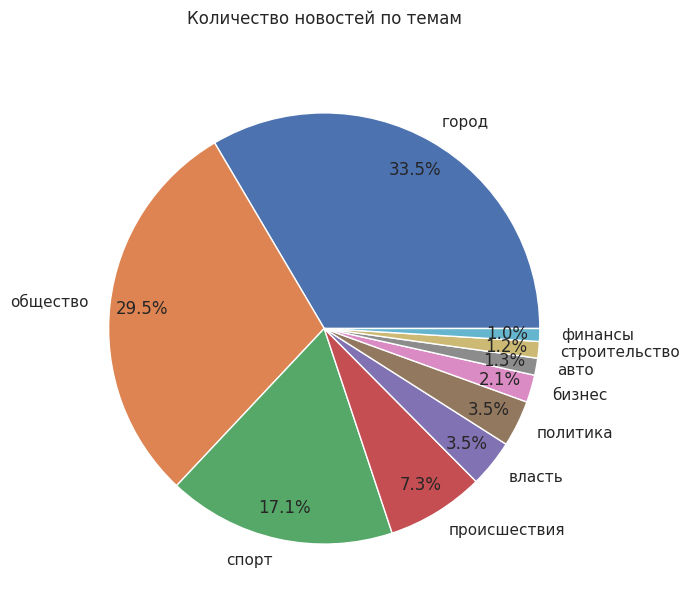

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
plt.pie(df['topic'].value_counts(),
        labels=df['topic'].unique(),
        autopct='%1.1f%%',
        pctdistance=0.85)
plt.title('Количество новостей по темам', y=1.05)

## Количество символов, слов, предложений

Добавим две колонки - длина символов.

In [ ]:
lenght = len(df['content'][0])
print(f'Количество символов в образце: {lenght}')

Количество символов в образце: 1570


In [ ]:
df['len_title'] = df['title'].str.len()
df['len_content'] = df['content'].str.len()

Распределения имеют длинные хвосты, поэтому сразу отобразим в логнормальном представлении

Text(0.5, 1.0, 'Length of content')

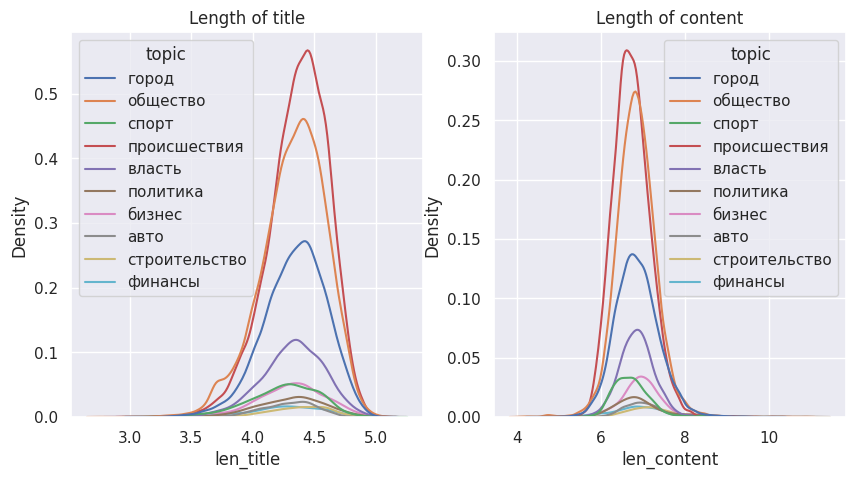

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.kdeplot(x=np.log(df['len_title'] + 1), hue=df['topic'], ax=axs[0])
axs[0].set_title('Length of title')

sns.kdeplot(x=np.log(df['len_content'] + 1), hue=df['topic'], ax=axs[1])
axs[1].set_title('Length of content')

**Выводы:**
- визуально сложно отметить различия в средних значениях в группах по длине заголовков или длине самой статьи. Рассмотрим это чуть ниже в гипотезах.

Добавим колонку: количество слов

In [ ]:
word_count = df['content'][0].split()
print(f'Количество слов в образце: {len(word_count)}')

Количество слов в образце: 225


In [ ]:
def word_count(text: str) -> int:
    """
    Функция подсчёта слов

    :param text: текст
    :return: количество слов
    """
    text_list = text.split()
    return len(text_list)

In [ ]:
df['word_count'] = df['content'].apply(word_count)

Распределение имеет длинные хвосты, поэтому сразу отобразим в логнормальном представлении

<Axes: xlabel='word_count', ylabel='Density'>

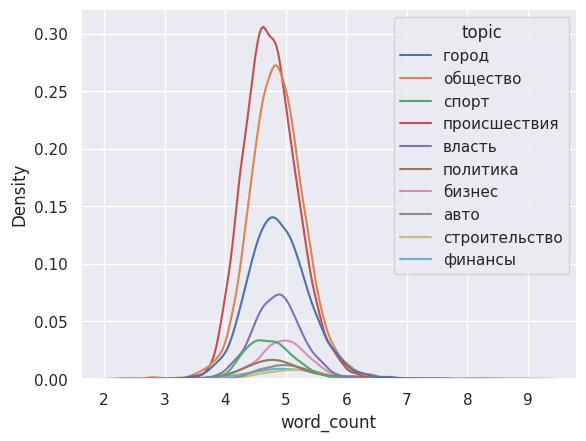

In [ ]:
sns.kdeplot(x=np.log(df['word_count'] + 1), hue=df['topic'])

**Выводы:**
- визуально среднее количество слов в группах отличается (см. выводы ко всему пункту ниже)

Добавим колонку: средняя длина слова в тексте

In [ ]:
df['mean_word_length'] = df['content'].map(lambda cont: np.mean([len(word) for word in cont.split()]))

<Axes: xlabel='mean_word_length', ylabel='Density'>

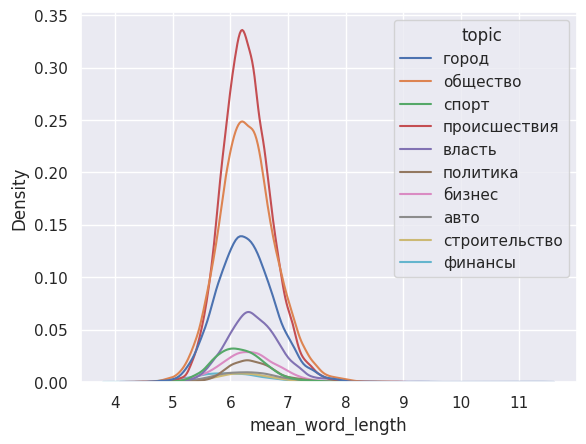

In [ ]:
sns.kdeplot(x=df['mean_word_length'], hue=df['topic'])

**Выводы:**
- визуально отличий между группами нет (см. выводы ко всему пункту ниже)

Добавим колонку: количество предложений

Определим предложения как заканчивающиеся на точку, вопрос, восклицательный знак

In [ ]:
# Добавляем столбец с количеством предложений
df['num_sentences'] = df['content'].apply(lambda x: len(re.findall(r'[.!?]', x)) if isinstance(x, str) else 0)

<Axes: xlabel='num_sentences', ylabel='Density'>

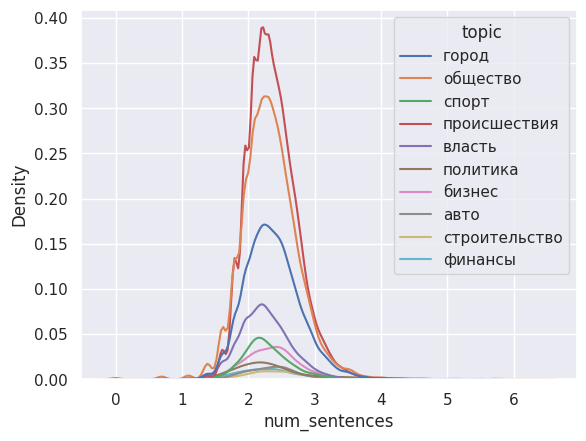

In [ ]:
sns.kdeplot(x=np.log(df['num_sentences'] + 1), hue=df['topic'])

**Выводы:**
- визуально отличий между группами нет (см. выводы ко всему пункту ниже)

Рассмотрим матрицу корреляций

In [ ]:
def corr_matrix(all_data: pd.DataFrame,
                width: int = 5,
                height: int = 5) -> matplotlib.figure.Figure:
    """
    Функция отображения матрицы корреляции
    :param all_data: датафрейм
    :param width: ширина
    :param height: высота
    :return: график
    """

    fig = plt.figure(figsize=(width, height))
    sns.set_style("whitegrid")

    mask = np.triu(np.ones_like(all_data.corr(
        numeric_only=True
    ), dtype=bool))

    heatmap = sns.heatmap(all_data.corr(
        numeric_only=True
    ).round(2),
                          annot=True,
                          square=True,
                          cmap="BrBG",
                          cbar_kws={"fraction": 0.01},
                          linewidth=2,
                          mask=mask,
                          )

    heatmap.set_title("Треугольная тепловая карта корреляции Пирсона",
                      fontdict={"fontsize": 11}, pad=5)

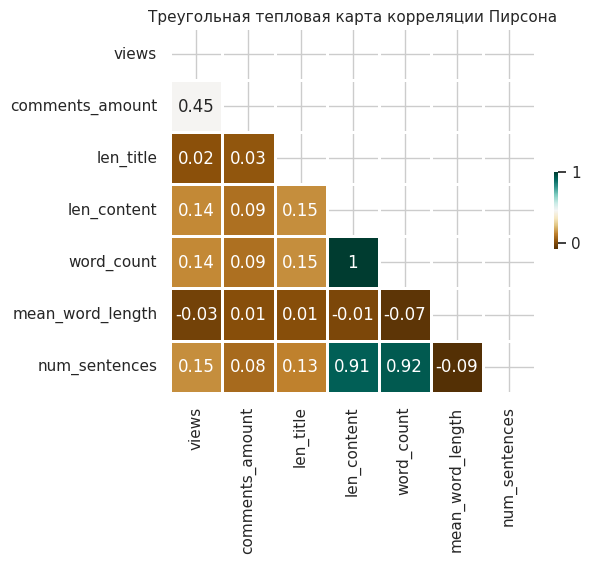

In [ ]:
corr_matrix(df)

**Выводы:**
- количество предложений, длина текста, количество слов в тексте имеют линейную корреляцию, а потому возможно не столь интересны для использования в модели
- средняя длина слов не имеет линейной корреляции

## Гипотезы

### Распределение по длине заголовка и длине самого текста

**Гипотезы:** есть зависимость длин заголовков в разных темах, а также отличаются длины самих текстов

In [ ]:
def oneway_anova(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Функция проведения одностороннего ANOVA
    """
    df_temp = df.copy()
    df_temp=df_temp[['topic', col]]
    model = ols(f'{col} ~ C(topic)', data=df_temp).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table['PR(>F)']['C(topic)']
    if p_value < 0.05:
        print(f'Существует статистически значимая'
              f' разница между средними {col} групп по темам.')
    else:
        print('Нет статистически значимой разницы между средними значениями.')
    return anova_table

In [ ]:
oneway_anova(df, 'len_content')

Существует статистически значимая разница между средними len_content групп по темам.


,sum_sq,df,F,PR(>F)
C(topic),6.481486e+08,9.0,76.749379,8.606684e-142
Residual,4.265852e+10,45462.0,NaN,NaN


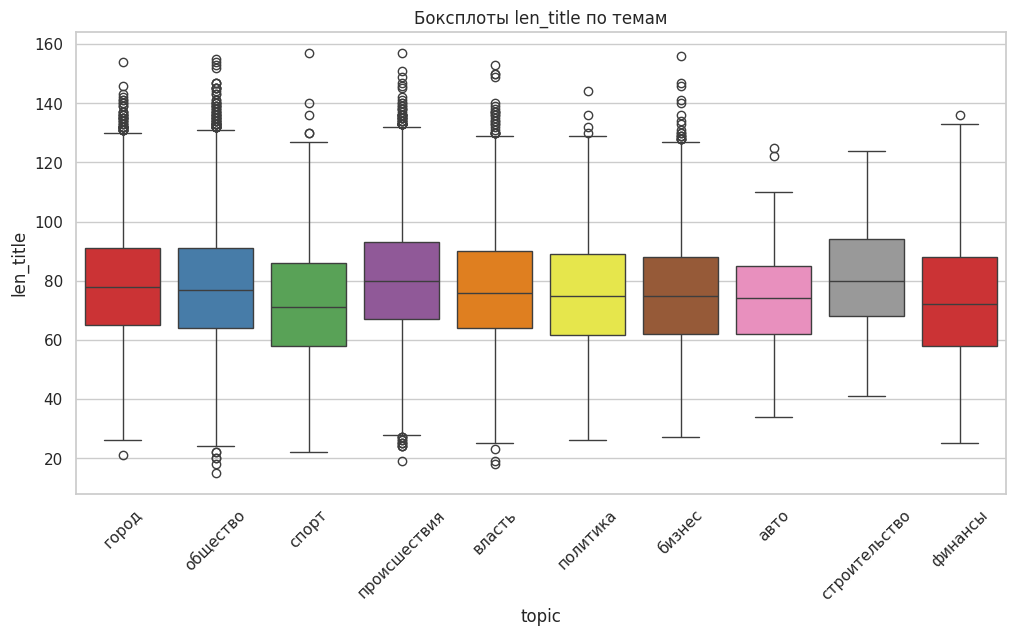

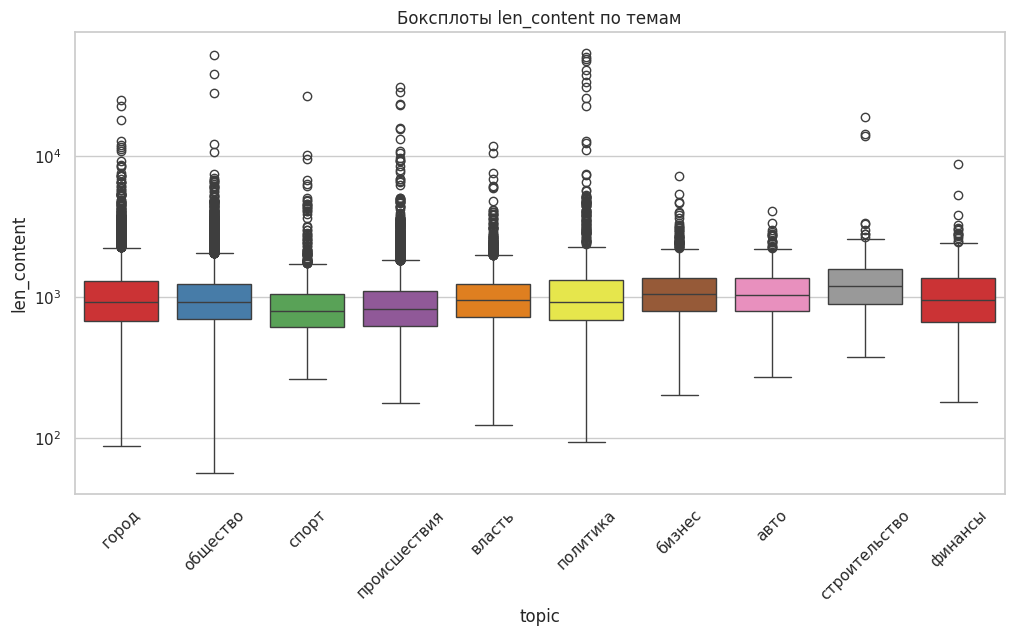

In [ ]:
for col in ['len_title', 'len_content']:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)
    n_topics = len(df.topic.unique())
    # ax.set_xticks(range(n_topics))
    ax.xaxis.set_major_locator(plt.FixedLocator(range(n_topics)))
    ax.set_xticklabels(df.topic.unique(), rotation=45)
    sns.boxplot(x="topic", y=col, data=df, hue="topic", palette="Set1", ax=ax)
    if col == 'len_content':
        ax.set_yscale('log') # Изменяем масштаб оси Y на логарифмический
    plt.title(f'Боксплоты {col} по темам');

**Выводы:**
- длина заголовков в большинстве тем в среднем достаточно близка, обычено ниже 80 символов.
- может быть можно говорить, что в тематике "спорт" длина заголовков несколько ниже средней
- по длине текстов у нас во множестве тематик наблюдаются длинные хвосты
- по средней длине текстов по тесту ANOVA имеем большие статистически значимое различие, и визуально на боксплотах видно, чтоминимальные длины текстов отличаются у разных тематик достаточно сильно

### Распределение по средней длине слов в тексте

**Гипотезы:** есть зависимость средней длины слов в тексте от тематики

<Axes: xlabel='mean_word_length', ylabel='topic'>

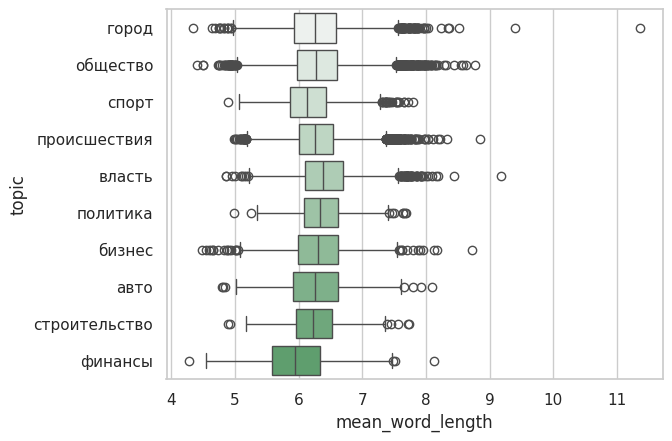

In [ ]:
sns.boxplot(x='mean_word_length',
            y="topic",
            data=df,
            hue="topic",
            palette="light:g")

In [ ]:
oneway_anova(df, 'mean_word_length')

Существует статистически значимая разница между средними mean_word_length групп по темам.


,sum_sq,df,F,PR(>F)
C(topic),146.546767,9.0,76.526178,2.291800e-141
Residual,9673.246323,45462.0,NaN,NaN


**Выводы**
- средние длины слов в текстах отличаются по тематикам. Это подтверждается статистическим текстом
- меньшая средняя длина слов наблюдается в теме финансы

### Распределение количества новостей по годам, месяцам и дням недели

**Гипотеза:** у нас есть зависимость распределения количества новостей по временным шкалам.

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True)

In [ ]:
# df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.strftime("%B")
df['weekday'] = df['datetime'].dt.strftime('%A')
df['hour'] = df['datetime'].dt.hour

In [ ]:
def visual_count_data(df: pd.DataFrame,
                      col: str,
                      pal: str='tab10',
                      x:int=10,
                      y:int=6) -> None:
    """
    Функция для отрисовки подсчёта элементов по времени

    :param df: датафрейм
    :param col: столбец
    :param pal: цветовая схема
    :param x: размер по оси x
    :param y: размер по оси y
    """

    plt.figure(figsize=(x, y))

    sns.countplot(x=df[col],
                  hue=df[col],
                  legend=False,
                  palette=pal,
                  order=df[col].value_counts(ascending=True).index)
    # Получаем данные для отображения процентов
    counts = df[col].value_counts()
    total = df[col].count()
    percents = counts / total * 100

    # Отсортируем проценты в том же порядке, что и столбцы
    percents = percents.sort_index(ascending=True)

    # Отображаем проценты над столбцами
    for i, col in enumerate(df[col].value_counts(ascending=True).index):
        percent = percents[col]
        plt.text(i, percent + 500, f'{percent:.1f}%', ha='center')

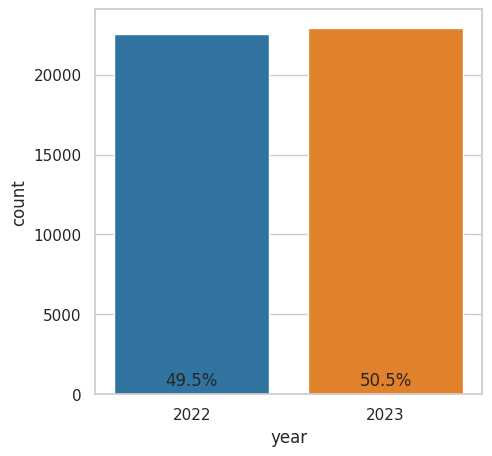

In [ ]:
visual_count_data(df,'year', x=5, y=5)

Данные за два года. По годам данные сбалансированы.

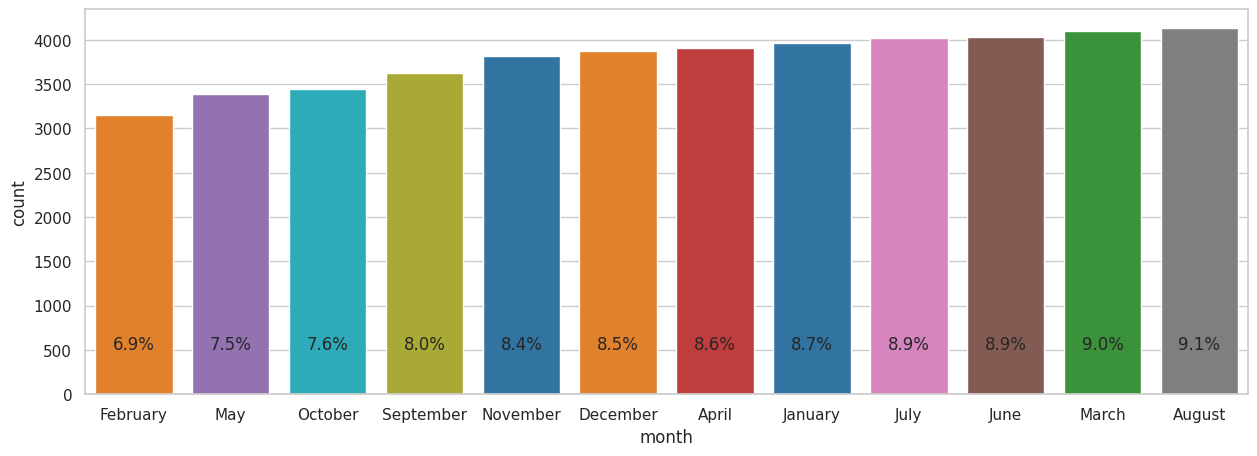

In [ ]:
visual_count_data(df,'month', x=15, y=5)

В феврале публикуется меньше всего новостей. Вероятно, просто из-за продолжительности месяца.

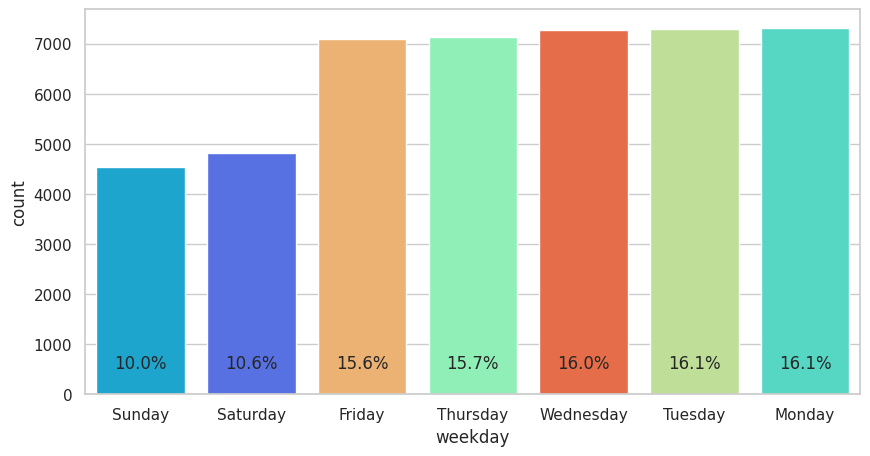

In [ ]:
visual_count_data(df,'weekday', 'rainbow', x=10, y=5)

По выходным публикуется меньше всего новостей.

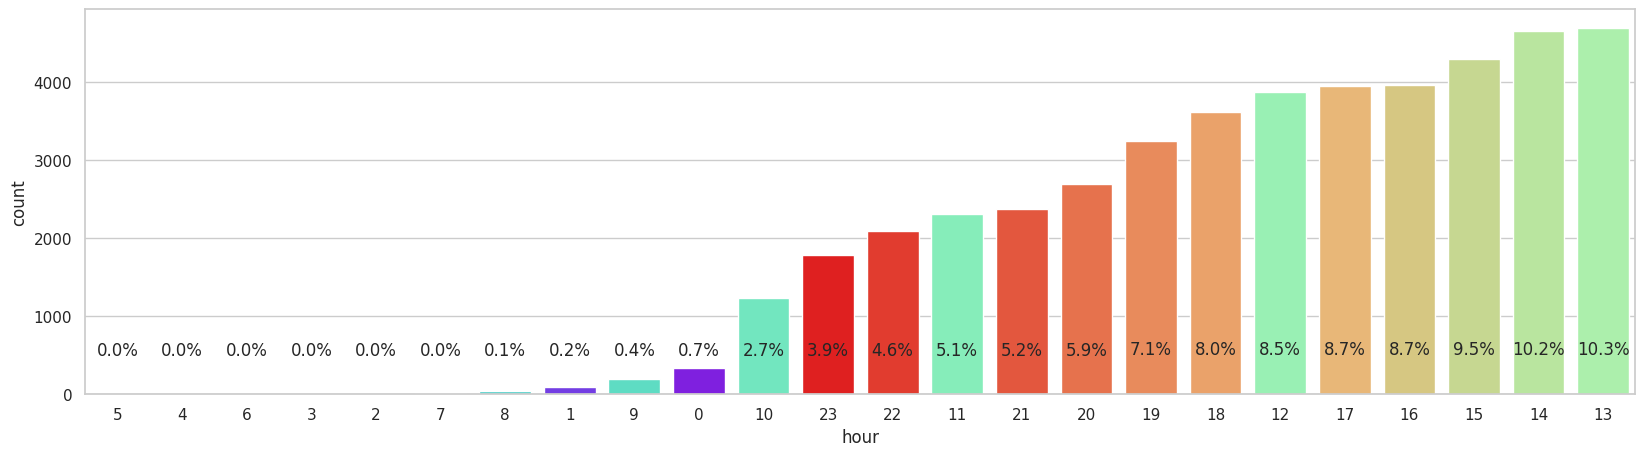

In [ ]:
visual_count_data(df,'hour', 'rainbow', x=20, y=5)

<Axes: xlabel='hour', ylabel='Density'>

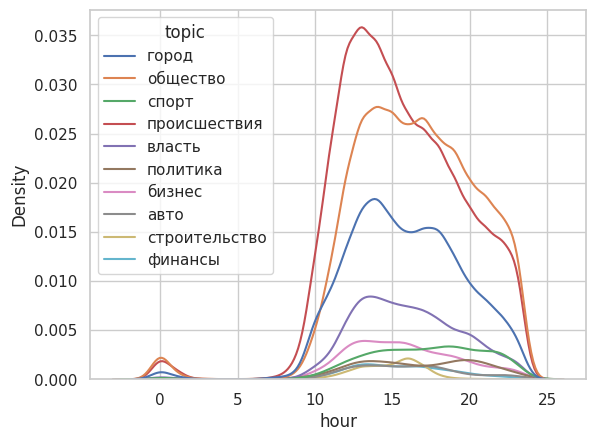

In [ ]:
sns.kdeplot(data=df,
            x='hour',
            hue='topic')

In [ ]:
oneway_anova(df, 'hour')

Существует статистически значимая разница между средними hour групп по темам.


,sum_sq,df,F,PR(>F)
C(topic),9186.538447,9.0,70.788584,1.975795e-130
Residual,655533.213994,45462.0,NaN,NaN


**Выводы:**
- данные за 2 года
- у нас есть зависимость публикации разных тем и количества публикаций от времени
- больше всего статей приходится на август. меньше всего на февраль - вероятно из-за количества дней в этом месяце
- по выходным дням у нас существенное уменьшение количества публикуемых новостей.
- можно видеть, что, например, происшествия публикуются чаще всего с утра и в выходные дни

### Распределение по числу просмотров

**Гипотеза:** статьи на определенные темы привлекают больше просмотров, чем статьи на другие темы.

Рассмотрим распределение просмоторов

<ipython-input-106-737be1f1b5cc>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


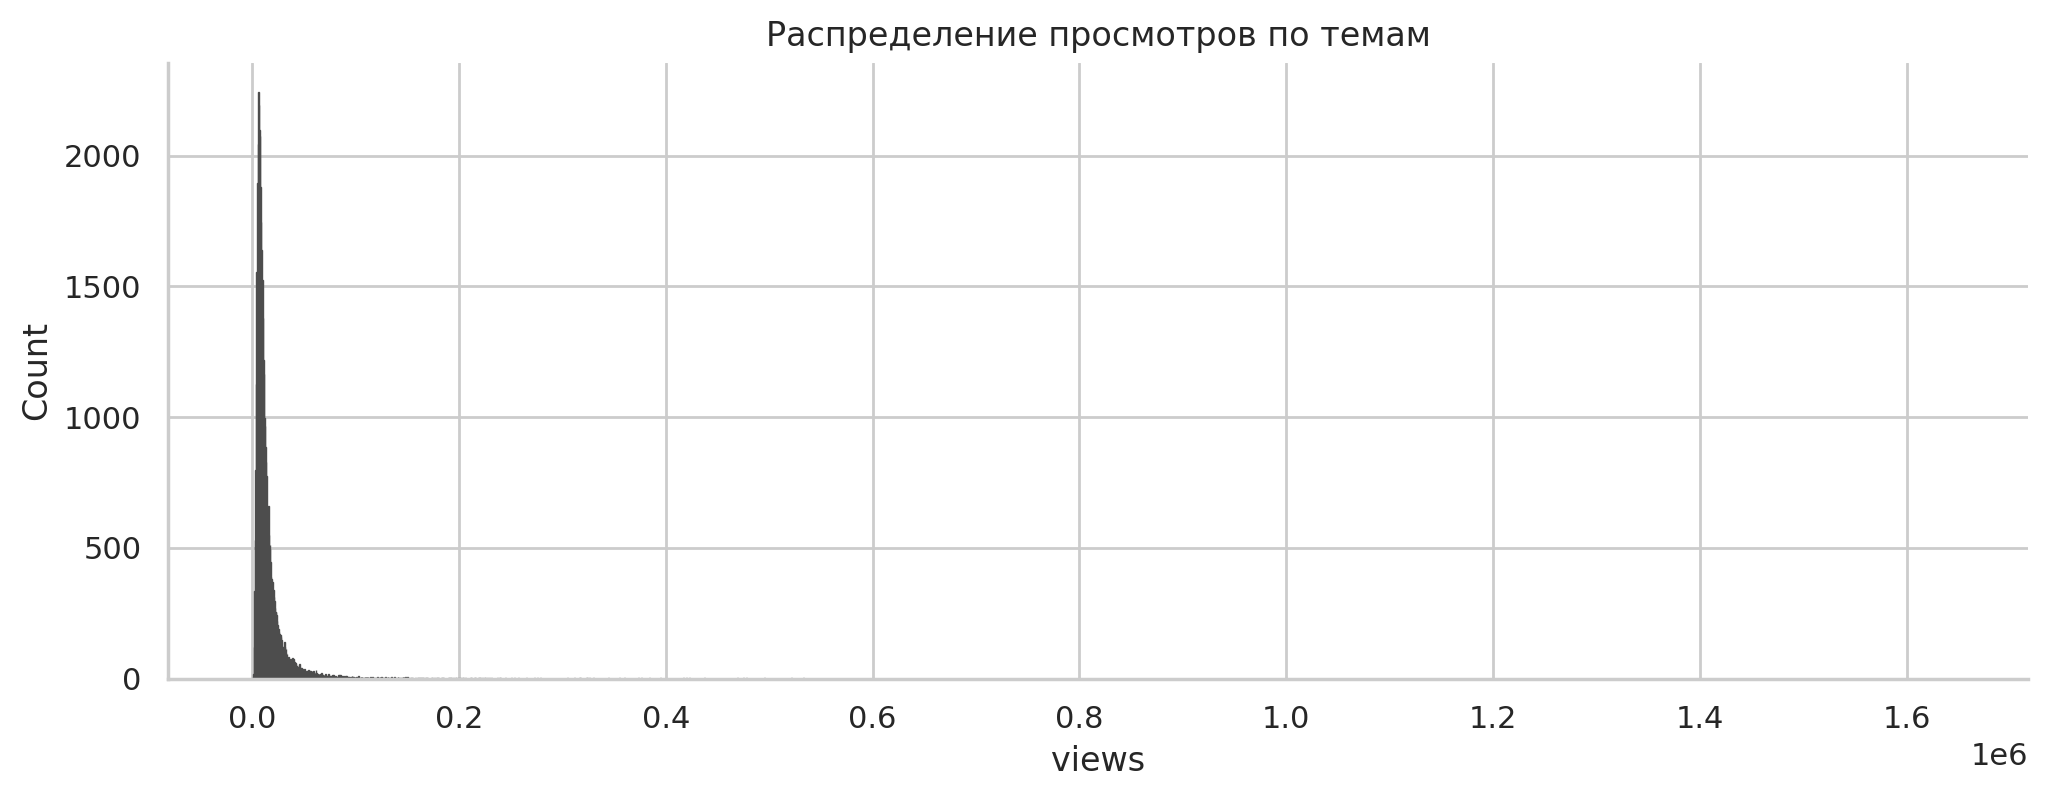

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Распределение просмотров по темам');

Форма распределения похожа на логнормальное распределение. Добавим еще один признак - логарифм количества просмотров, сдвинутого на единицу, поскольку количество просмотров может принимать значение ноль.

In [ ]:
df['log_views'] = np.log1p(df['views'])

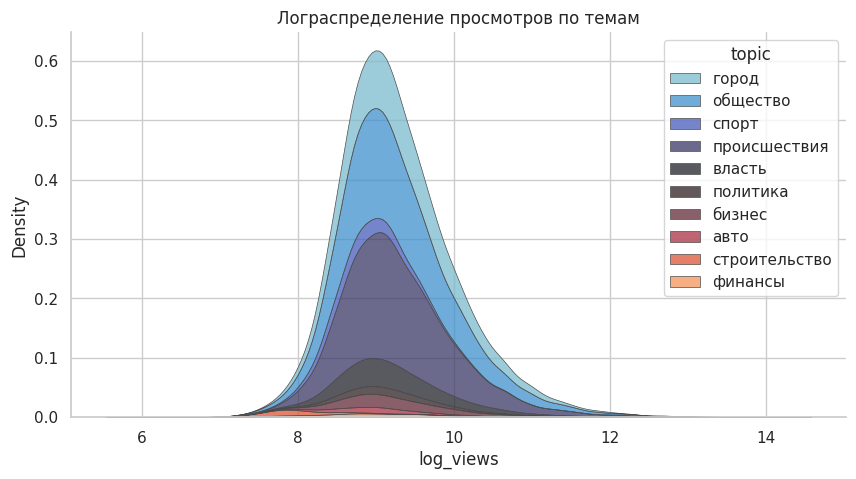

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
sns.despine(fig)

sns.kdeplot(
    df,
    x="log_views",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="icefire",
    linewidth=.5,
);
axs.set_title('Лограспределение просмотров по темам');

In [ ]:
from scipy.stats import mannwhitneyu

# Генерируем выборку из нормального распределения с таким же мат. ожиданием
#  и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['log_views'].mean(),
                     scale=df['log_views'].std(),
                     size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['log_views'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение количества просмотров можно считать логнормальным')
else:
    print('Распределение количества просмотров нельзя считать логнормальным')

P-значимость: 2.3737346311229353e-26
Распределение количества просмотров можно считать логнормальным


In [ ]:
df.groupby('topic').agg(min_views =('views', 'min'),
                        max_views=('views', 'max'),
                        avg_views=('views', 'mean'),
                        median_views=('views', 'median'),
                        total_views=('views', 'sum')).sort_values(by='total_views',
                                                                  ascending=False)

,min_views,max_views,avg_views,median_views,total_views
topic,,,,,
происшествия,1671,602238,15457.572104,9955.0,235387908
общество,332,593513,16284.659189,9723.5,218507557
город,1293,1087024,16245.887503,10367.5,126360513
власть,1450,1635672,14964.108780,9423.0,49935231
бизнес,527,186488,13453.548040,9259.0,21283513
политика,2056,358808,15537.833333,9513.0,14543412
спорт,481,265581,8652.998138,6795.0,13939980
финансы,1295,218669,13615.440708,7799.0,7692724
авто,1736,68940,9756.489655,7765.5,5658764


In [ ]:
oneway_anova(df, 'views')

Существует статистически значимая разница между средними views групп по темам.


,sum_sq,df,F,PR(>F)
C(topic),1.786676e+11,9.0,35.314511,7.272763e-63
Residual,2.555634e+13,45462.0,NaN,NaN


**Выводы**
- у нас есть различия в количестве просмотров по тематикам

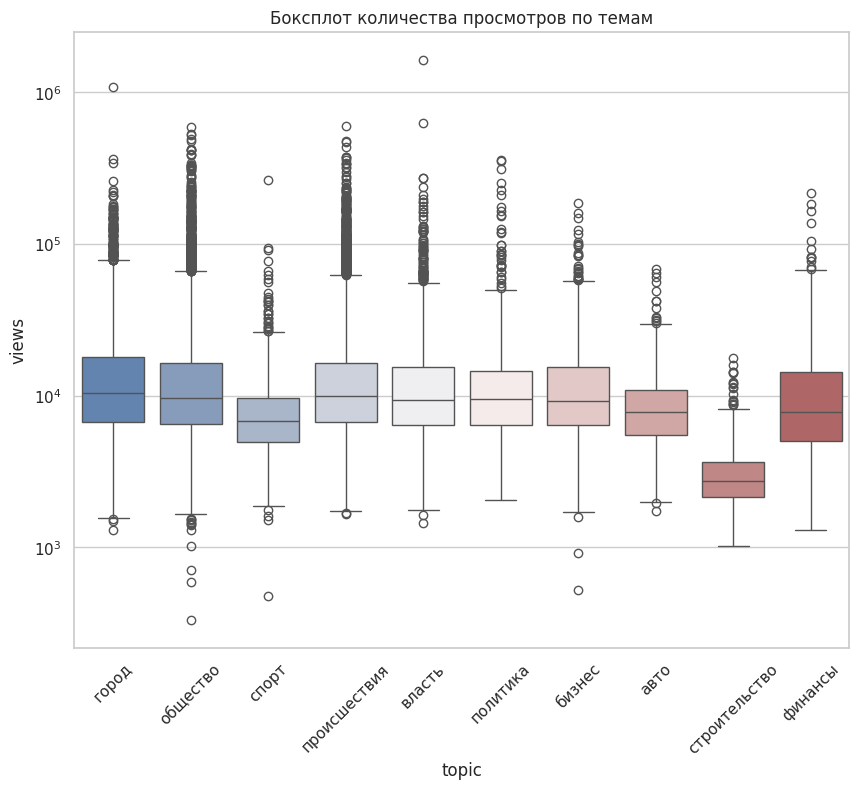

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
# получаем количество уникальных значений в столбце topic
n_topics = len(df.topic.unique())
ax.set_xticks(range(n_topics))
ax.set_xticklabels(df.topic.unique(), rotation=45)
# устанавливаем логарифмическую шкалу по вертикали
ax.set_yscale('log')
sns.boxplot(x="topic", y="views", data=df, ax=ax, palette='vlag', hue='topic')
plt.title('Боксплот количества просмотров по темам');

**Выводы:**
- у нас есть большие выбросы по количеству просмотров, особенно по тематике "власть"
- также у нас есть большие хвосты в распределениях
- по темам "строительство", "спорт", "авто" у нас просмотры ниже, чем в других тематиках

### Наиболее популярные слова в тексте

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

In [ ]:
frequencies = {}

# Построение барплотов для топ-5 слов в каждой теме
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]
    # Подсчёт частот встречаемости слов в каждой теме
    frequencies[topic] = collections.Counter(words)

    # Выбор топ-5 слов
    top_5 = frequencies[topic].most_common(5)
    # Создание DataFrame для построения барплота
    df_top_5 = pd.DataFrame(top_5, columns=['word', 'frequency'])
    # Сортировка DataFrame по столбцу 'frequency' в порядке убывания
    df_top_5 = df_top_5.sort_values('frequency', ascending=False)
    # Построение барплота
    ax = sns.barplot(y='word',
                     x='frequency',
                     hue='word',
                     data=df_top_5,
                     palette='tab10')
    # Настройка отображения
    plt.title(f"Топ 5 слов по теме {topic}", fontsize=30)
    plt.xlabel("Частота")
    plt.ylabel("Слова")
    plt.tight_layout()
    plt.show()

    wc = WordCloud(background_color="grey", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Самые частые слова в теме {topic}", fontsize=30)
    ax.imshow(wc, alpha=0.98)

    print('*'*200)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

**Выводы:**
- статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на будущую модель

### Распределение по времени жизни

**Гипотеза:** есть зависимость количества просмотров в минуту

In [ ]:
df['lifetime'] = pd.to_datetime(df['datetime'], utc=True).\
      apply(lambda x: (datetime.datetime.now(datetime.timezone.utc) - x).\
      total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # в минутах

В выборку попали статьи с разной временем жизни, т.е. как старые, так и совершенно новые статьи. Это влияет на количество просмотров. Поэтому для корректной работы модели необходимо будет каким-то образом отнормировать этот признак. Для этого сначала посмотрим распределение возраста статей, а затем распределение отношения количества просмотров к возрасту статьи.

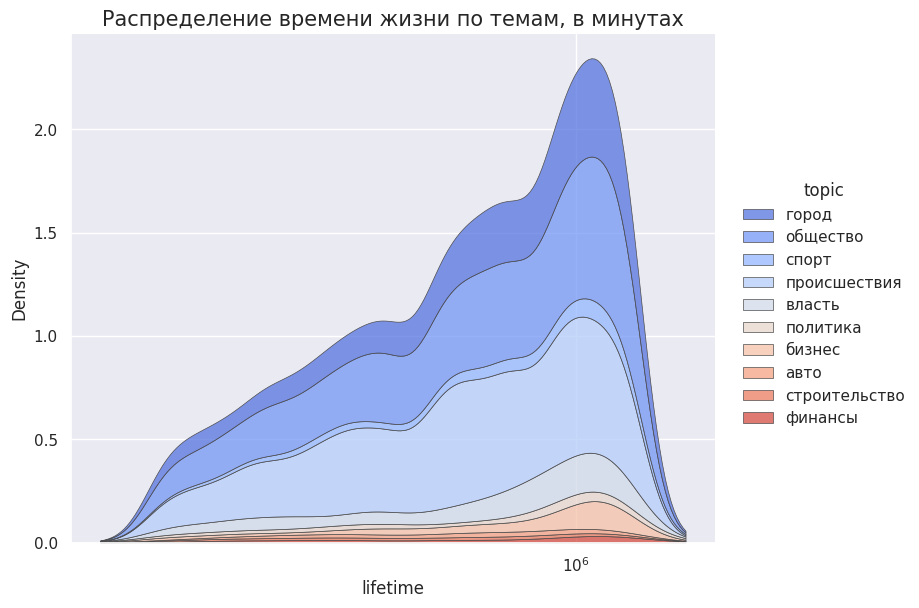

In [ ]:
sns.set_theme(style="darkgrid")
sns.displot(
    data=df,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
    kind='kde',
    height=6,
    aspect=1.25
);

plt.title('Распределение времени жизни по темам, в минутах', fontsize=15);

в датасете присутствуют как старые статьи, так и новые

In [ ]:
df['views_by_minutes'] = (df['views'] + 1) / df['lifetime']
df['log_views_by_minutes'] = np.log1p(df['views_by_minutes'])

Новый признак: количество просмотров в минуту, или средняя скорость роста количества просмотров - имеет распределение, близкое к логнормальному.

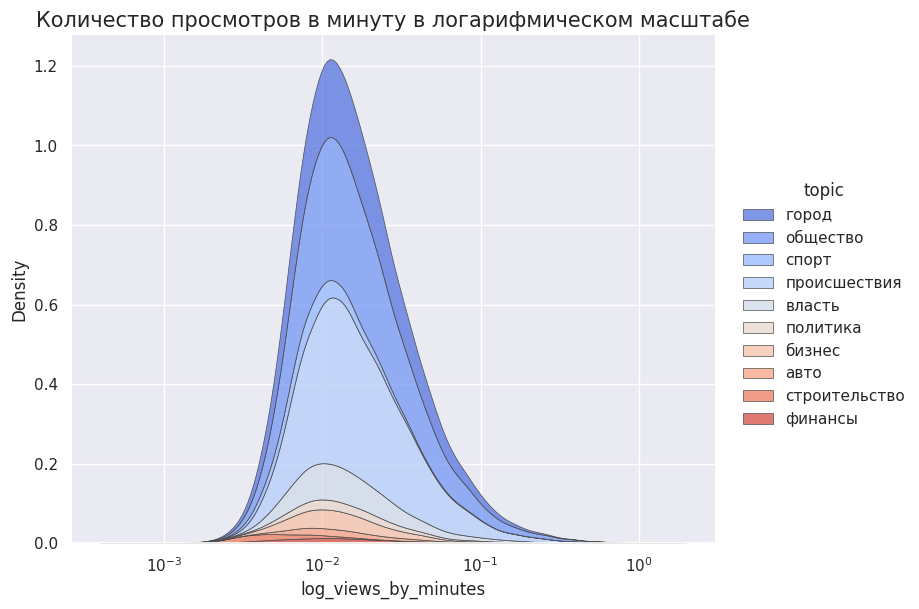

In [ ]:
sns.displot(
    data=df,
    x="log_views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
    kind='kde',
    height=6,
    aspect=1.25
);

plt.title('Количество просмотров в минуту в логарифмическом масштабе', fontsize=15);

**Выводы:**
- Одним признаков является количество просмотров, поскольку в каждый период времени наиболее популярными будут статьи на актуальные для данного промежутка времени темы. Однако, количество просмотров сильно зависит от возраста статьи, поэтому добавиляем новый признак - средняя скорость роста количества просмотров.

# Получение подготовленного датасета

In [ ]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки,
# которые не потребуются для анализа
cat_features = [#'title',
                #'content',
                'month',
                'weekday']

targets = ['topic']
features2drop = ['url', 'views', 'views_by_minutes', 'lifetime', 'datetime',
                 'title', 'word_count', 'num_sentences', 'mean_word_length']
txt_features = ['content']

filtered_features = [i for i in df.columns if (i not in features2drop)]
num_features = [i for i in filtered_features if(i not in cat_features and i not in txt_features)]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtext_features:\033[0m {txt_features}, \033[1mamount\033[0m = {len(txt_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['month', 'weekday'], amount = 2
num_features: ['topic', 'comments_amount', 'len_title', 'len_content', 'year', 'hour', 'log_views', 'log_views_by_minutes'], amount = 8
text_features: ['content'], amount = 1
targets: ['topic'], amount = 1


In [ ]:
df = df[filtered_features]

In [ ]:
df.to_csv('df_prepared.csv', index=False)